In [21]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt

warnings.filterwarnings('ignore')

In [22]:
# Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.
# Period of Record: March 1958 - December 2001

data = sm.datasets.co2.load_pandas()
df = data.data
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [23]:
print(df.index.dtype)  # If object or string, convert to datetime


datetime64[ns]


In [24]:
df = df.resample('MS').mean()


In [25]:
df.isnull().sum()

co2    5
dtype: int64

In [26]:
df = df.fillna(df.bfill())

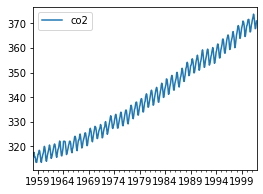

In [27]:
df.plot(figsize=(4, 3))
plt.show()

In [28]:
# Holdout

train = df[:'1997-12-01']
len(train)  # 478 months

478

In [29]:
# Define the test set as data from January 1998 to the end of 2001
test = df['1998-01-01':]

# Verify the length of the test set, which should be 48 months (4 years)
len(test)  # 48 months


48

## Dickey-Fuller Stationary Test

In [66]:
def is_stationary(df):
    """
    Performs the Augmented Dickey-Fuller (ADF) test to check stationarity of a given time series.

    Null hypothesis (H0): The series is non-stationary.
    Alternative hypothesis (H1): The series is stationary.

    Parameters:
    -----------
    df : pandas.Series or pandas.DataFrame
        The time series data to be tested.

    Returns:
    --------
    None
        Prints out the result indicating if the series is stationary or non-stationary
        along with the corresponding p-value.

    Interpretation:
    ---------------
    - If p-value < 0.05: Reject the null hypothesis (H0), concluding the series is stationary.
    - If p-value >= 0.05: Fail to reject the null hypothesis, concluding the series is non-stationary.

    Example:
    --------
    >>> is_stationary(df)
    Result: Stationary (H0: non-stationary, p-value: 0.023)
    """

    p_value = sm.tsa.stattools.adfuller(df)[1]

    if p_value < 0.05:
        print(f"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(f"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")




In [67]:
is_stationary(df)

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


##  Time Series Decomposition

In [69]:
def ts_decompose(df, model="additive", stationary=False):
    """
    Performs time series decomposition on a given DataFrame or Series and optionally conducts a stationarity test.

    Parameters:
    ----------
    df : pandas Series or DataFrame
        Time series data to decompose. Index must be datetime-like.

    model : str, optional, default "additive"
        The type of decomposition to perform. Options are:
            - "additive": Assumes components (trend, seasonal, residual) add together to form the series.
            - "multiplicative": Assumes components multiply together to form the series.

    stationary : bool, optional, default False
        If True, performs and displays the results of the Augmented Dickey-Fuller (ADF) test 
        to determine if the time series is stationary.

    Returns:
    -------
    None
        Displays the decomposition plots (original data, trend, seasonality, residuals) 
        and optionally prints the stationarity test results.

    Example:
    --------
    ts_decompose(df, model="multiplicative", stationary=True)
    """
    result = seasonal_decompose(df, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(df, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(df)




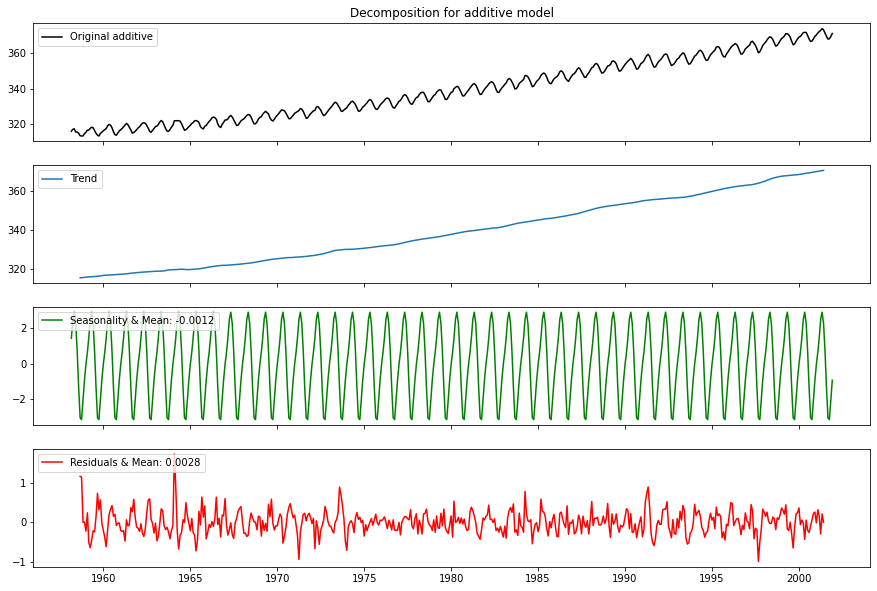

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


In [70]:
ts_decompose(df, stationary=True)

In [71]:
# Fit Simple Exponential Smoothing (SES) model and forecast future values
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.5)

# Generate forecast for the next 48 periods (e.g., months)
y_pred = ses_model.forecast(48)

# Calculate and print Mean Absolute Error (MAE) rounded to 2 decimal points
round(mean_absolute_error(test, y_pred), 2)

5.71

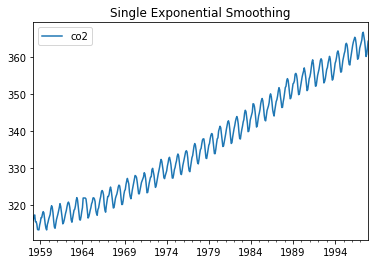

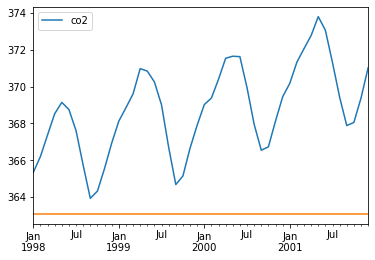

In [72]:
train.plot(title="Single Exponential Smoothing")
test.plot()
y_pred.plot()
plt.show()

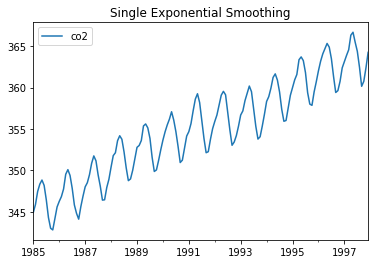

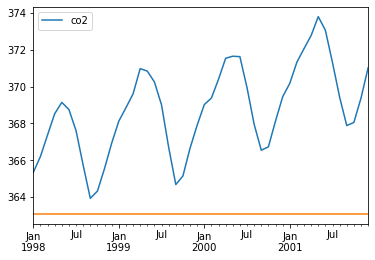

In [73]:
train["1985":].plot(title="Single Exponential Smoothing")
test.plot()
y_pred.plot()
plt.show()


In [74]:
def plot_co2(train, test, y_pred, title):
    """
    Plots training data, test data, and predictions for CO2 levels, including the Mean Absolute Error (MAE).

    Parameters:
    -----------
    train : pandas.Series or pandas.DataFrame
        The training set data used to fit the model.

    test : pandas.Series or pandas.DataFrame
        The actual observed values used to evaluate the model performance.

    y_pred : pandas.Series or pandas.DataFrame
        The forecasted values predicted by the model.

    title : str
        The title of the plot, describing the model or scenario.

    Returns:
    --------
    None
        Displays a matplotlib plot showing the training data, test data, predictions, and the MAE metric.

    Example:
    --------
    plot_co2(train, test, y_pred, "Simple Exponential Smoothing")
    """
    mae = mean_absolute_error(test, y_pred)
    train["1985":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae, 2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()


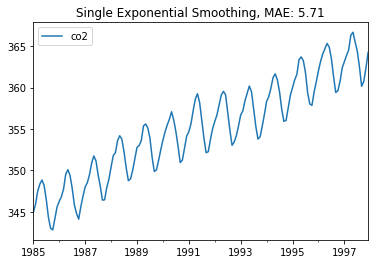

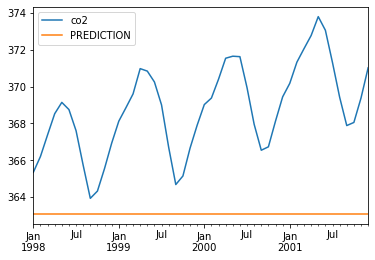

In [75]:
plot_co2(train, test, y_pred, "Single Exponential Smoothing")

In [76]:
ses_model.params

{'smoothing_level': 0.5,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 316.4419309772571,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [77]:
def ses_optimizer(train, alphas, step=48):
    """
    Optimizes the smoothing parameter (alpha) for Simple Exponential Smoothing by minimizing the Mean Absolute Error (MAE).

    Parameters:
    -----------
    train : pandas.Series or pandas.DataFrame
        The training set data used to fit the model.

    alphas : iterable
        A sequence of alpha values (between 0 and 1) to test for optimization.

    step : int, optional, default 48
        The number of periods ahead to forecast.

    Returns:
    --------
    best_alpha : float
        The optimal alpha value resulting in the lowest MAE.

    best_mae : float
        The lowest Mean Absolute Error achieved with the best alpha.

    Prints the MAE for each tested alpha and displays the best alpha with its MAE.

    Example:
    --------
    alphas = np.arange(0.8, 1, 0.01)
    best_alpha, best_mae = ses_optimizer(train, alphas)
    """
    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae



In [79]:
alphas = np.arange(0.8, 1, 0.01)

In [80]:
best_alpha, best_mae = ses_optimizer(train, alphas)



alpha: 0.8 mae: 4.953
alpha: 0.81 mae: 4.9282
alpha: 0.82 mae: 4.9035
alpha: 0.83 mae: 4.8792
alpha: 0.84 mae: 4.8551
alpha: 0.85 mae: 4.8316
alpha: 0.86 mae: 4.8091
alpha: 0.87 mae: 4.7869
alpha: 0.88 mae: 4.765
alpha: 0.89 mae: 4.7434
alpha: 0.9 mae: 4.7221
alpha: 0.91 mae: 4.7012
alpha: 0.92 mae: 4.6805
alpha: 0.93 mae: 4.6602
alpha: 0.94 mae: 4.6402
alpha: 0.95 mae: 4.6205
alpha: 0.96 mae: 4.6012
alpha: 0.97 mae: 4.5822
alpha: 0.98 mae: 4.5634
alpha: 0.99 mae: 4.5451
best_alpha: 0.99 best_mae: 4.5451


In [81]:
best_alpha, best_mae

(0.9900000000000002, 4.545056761011273)

In [82]:
print(round(best_alpha,2), round(best_mae,2))

0.99 4.55


In [83]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(48)

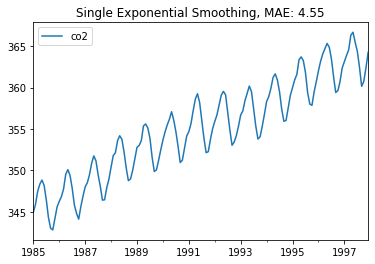

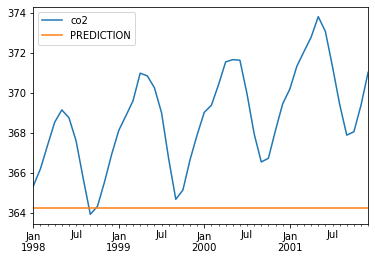

In [84]:
plot_co2(train, test, y_pred, "Single Exponential Smoothing")

In [85]:
des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=0.5,
                                                         smoothing_trend=0.5)

In [86]:
y_pred = des_model.forecast(48)

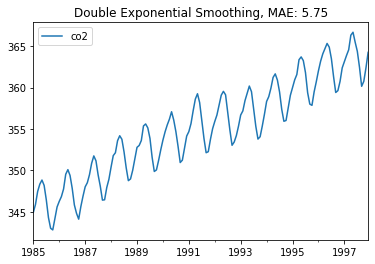

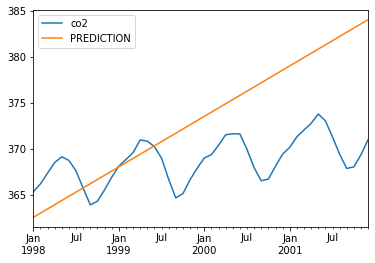

In [87]:
plot_co2(train, test, y_pred, "Double Exponential Smoothing")

In [88]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
import numpy as np

def des_optimizer(train, alphas, betas, step=48):
    """
    Finds optimal smoothing parameters (alpha and beta) for Double Exponential Smoothing (Holt's Linear Trend Method)
    by minimizing the Mean Absolute Error (MAE).

    Parameters:
    -----------
    train : pandas.Series or pandas.DataFrame
        The training data used to fit the model.

    alphas : iterable
        Sequence of alpha values (0 < alpha < 1) to test for the smoothing of the level component.

    betas : iterable
        Sequence of beta values (0 < beta < 1) to test for the smoothing of the trend component.

    step : int, optional (default=48)
        Number of periods to forecast ahead.

    Returns:
    --------
    best_alpha : float
        Alpha value achieving the lowest MAE.

    best_beta : float
        Beta value achieving the lowest MAE.

    best_mae : float
        The lowest Mean Absolute Error obtained from the tested alpha-beta combinations.

    Prints the MAE for each alpha-beta combination and highlights the best parameters.

    Example:
    --------
    alphas = np.arange(0.01, 1, 0.10)
    betas = np.arange(0.01, 1, 0.10)
    best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas)
    """

    best_alpha, best_beta, best_mae = None, None, float("inf")

    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(
                smoothing_level=alpha, smoothing_slope=beta
            )
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae

# Example usage:
alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)



In [89]:
best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas)

alpha: 0.01 beta: 0.01 mae: 2.3849
alpha: 0.01 beta: 0.11 mae: 2.8294
alpha: 0.01 beta: 0.21 mae: 2.744
alpha: 0.01 beta: 0.31 mae: 2.1723
alpha: 0.01 beta: 0.41 mae: 2.8895
alpha: 0.01 beta: 0.51 mae: 2.49
alpha: 0.01 beta: 0.61 mae: 1.8196
alpha: 0.01 beta: 0.71 mae: 1.7411
alpha: 0.01 beta: 0.81 mae: 2.1932
alpha: 0.01 beta: 0.91 mae: 4.8521
alpha: 0.11 beta: 0.01 mae: 2.4334
alpha: 0.11 beta: 0.11 mae: 3.9118
alpha: 0.11 beta: 0.21 mae: 6.0908
alpha: 0.11 beta: 0.31 mae: 7.2434
alpha: 0.11 beta: 0.41 mae: 8.7305
alpha: 0.11 beta: 0.51 mae: 10.3166
alpha: 0.11 beta: 0.61 mae: 12.0066
alpha: 0.11 beta: 0.71 mae: 13.9772
alpha: 0.11 beta: 0.81 mae: 16.4873
alpha: 0.11 beta: 0.91 mae: 19.655
alpha: 0.21 beta: 0.01 mae: 2.8218
alpha: 0.21 beta: 0.11 mae: 5.7217
alpha: 0.21 beta: 0.21 mae: 8.6538
alpha: 0.21 beta: 0.31 mae: 11.7598
alpha: 0.21 beta: 0.41 mae: 15.5277
alpha: 0.21 beta: 0.51 mae: 20.1474
alpha: 0.21 beta: 0.61 mae: 25.5273
alpha: 0.21 beta: 0.71 mae: 31.2781
alpha: 0.21 be

In [90]:
final_des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                               smoothing_slope=best_beta)

y_pred = final_des_model.forecast(48)

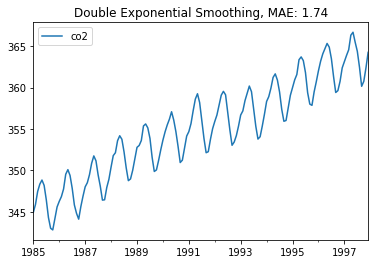

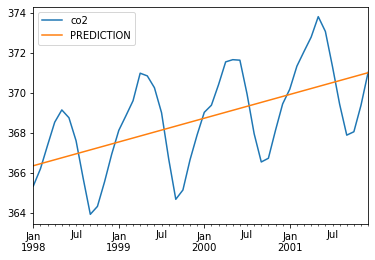

In [91]:
plot_co2(train, test, y_pred, "Double Exponential Smoothing")

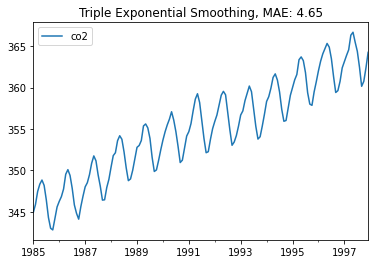

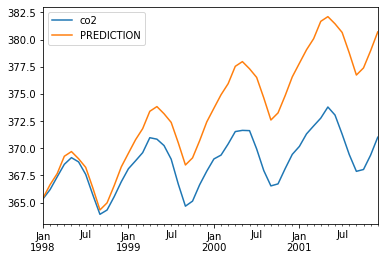

In [92]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit a Triple Exponential Smoothing (TES) model with additive trend and seasonality
tes_model = ExponentialSmoothing(
    train,
    trend="add",
    seasonal="add",
    seasonal_periods=12
).fit(
    smoothing_level=0.5,
    smoothing_slope=0.5,
    smoothing_seasonal=0.5
)

# Generate forecasts for the next 48 periods
y_pred = tes_model.forecast(48)

# Plot observed vs. predicted values along with the calculated MAE
plot_co2(train, test, y_pred, "Triple Exponential Smoothing")


In [93]:
alphas = betas = gammas = np.arange(0.20, 1, 0.05)

abg = list(itertools.product(alphas, betas, gammas))

In [94]:
def tes_optimizer(train, abg, step=48):
    """
    Finds optimal smoothing parameters (alpha, beta, gamma) for Triple Exponential Smoothing (TES) 
    by minimizing Mean Absolute Error (MAE).

    Parameters:
    ----------
    train : array-like
        Training dataset used for fitting the TES model.
    abg : list of tuples
        List containing combinations of (alpha, beta, gamma) smoothing parameters to evaluate.
        Each tuple should be in the format (alpha, beta, gamma), with each value between 0 and 1.
    step : int, default=48
        Number of steps (periods) ahead to forecast and evaluate.

    Returns:
    -------
    best_alpha : float
        Optimal smoothing level parameter (alpha) found.
    best_beta : float
        Optimal smoothing slope (trend) parameter (beta) found.
    best_gamma : float
        Optimal smoothing seasonal parameter (gamma) found.
    best_mae : float
        The minimum Mean Absolute Error (MAE) achieved among all parameter combinations.

    Prints:
    ------
    - MAE results for each parameter combination tested.
    - Best parameter combination with corresponding MAE.

    Usage:
    -----
    >>> best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg)
    """
    # Initialize best parameter placeholders and set initial best MAE to infinity.
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")

    # Iterate through all provided parameter combinations
    for comb in abg:
        # Fit a TES model using current parameters (alpha, beta, gamma)
        tes_model = ExponentialSmoothing(
            train, 
            trend="add", 
            seasonal="add", 
            seasonal_periods=12
        ).fit(
            smoothing_level=comb[0],     # alpha (level)
            smoothing_slope=comb[1],     # beta (trend)
            smoothing_seasonal=comb[2]   # gamma (seasonality)
        )

        # Forecast future values for 'step' periods ahead
        y_pred = tes_model.forecast(step)

        # Compute MAE between predicted values and true test values
        mae = mean_absolute_error(test, y_pred)

        # Check if current MAE is lower than previously recorded best MAE
        if mae < best_mae:
            # If better, update best parameters and best MAE
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae

        # Print the current parameter combination and its MAE (rounded)
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    # Print the best parameter combination and corresponding MAE found during optimization
    print("best_alpha:", round(best_alpha, 2), 
          "best_beta:", round(best_beta, 2), 
          "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    # Return best parameters and best MAE
    return best_alpha, best_beta, best_gamma, best_mae



In [95]:
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg)

[0.2, 0.2, 0.2, 0.88]
[0.2, 0.2, 0.25, 0.83]
[0.2, 0.2, 0.3, 0.79]
[0.2, 0.2, 0.35, 0.77]
[0.2, 0.2, 0.4, 0.76]
[0.2, 0.2, 0.45, 0.76]
[0.2, 0.2, 0.5, 0.75]
[0.2, 0.2, 0.55, 0.74]
[0.2, 0.2, 0.6, 0.72]
[0.2, 0.2, 0.65, 0.69]
[0.2, 0.2, 0.7, 0.67]
[0.2, 0.2, 0.75, 0.66]
[0.2, 0.2, 0.8, 0.67]
[0.2, 0.2, 0.85, 0.69]
[0.2, 0.2, 0.9, 0.71]
[0.2, 0.2, 0.95, 0.73]
[0.2, 0.25, 0.2, 0.66]
[0.2, 0.25, 0.25, 0.66]
[0.2, 0.25, 0.3, 0.68]
[0.2, 0.25, 0.35, 0.69]
[0.2, 0.25, 0.4, 0.69]
[0.2, 0.25, 0.45, 0.69]
[0.2, 0.25, 0.5, 0.7]
[0.2, 0.25, 0.55, 0.71]
[0.2, 0.25, 0.6, 0.73]
[0.2, 0.25, 0.65, 0.77]
[0.2, 0.25, 0.7, 0.83]
[0.2, 0.25, 0.75, 0.92]
[0.2, 0.25, 0.8, 1.01]
[0.2, 0.25, 0.85, 1.09]
[0.2, 0.25, 0.9, 1.12]
[0.2, 0.25, 0.95, 1.09]
[0.2, 0.3, 0.2, 0.86]
[0.2, 0.3, 0.25, 0.9]
[0.2, 0.3, 0.3, 0.93]
[0.2, 0.3, 0.35, 0.94]
[0.2, 0.3, 0.4, 0.94]
[0.2, 0.3, 0.45, 0.93]
[0.2, 0.3, 0.5, 0.95]
[0.2, 0.3, 0.55, 1.0]
[0.2, 0.3, 0.6, 1.09]
[0.2, 0.3, 0.65, 1.23]
[0.2, 0.3, 0.7, 1.43]
[0.2, 0.3, 0.75, 1.6

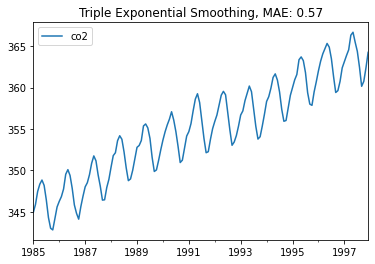

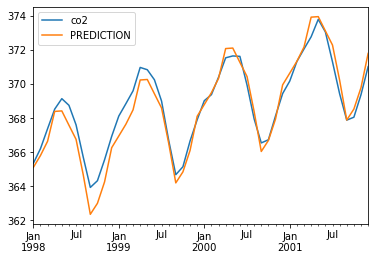

In [97]:
# Final TES model with optimized parameters
final_tes_model = ExponentialSmoothing(
    train,
    trend="add",
    seasonal="add",
    seasonal_periods=12
).fit(
    smoothing_level=best_alpha,
    smoothing_trend=best_beta,
    smoothing_seasonal=best_gamma
)

# Forecast next 48 periods using the final model
y_pred = final_tes_model.forecast(48)

# Plot actual vs forecasted values
plot_co2(train, test, y_pred, "Triple Exponential Smoothing")
